# Phase3
## Aliasghar Pourghani
## Saba Nasiri
## Dariush Ghaemi
## Part 1: Multimodal models with image and text

### Subpart 1: Concatenation

In [1]:
# import libraries
from yoloface import face_analysis
import numpy
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import numpy as np
import ast
from itertools import groupby
from operator import itemgetter
from collections import Counter
from PIL import Image
from tqdm import tqdm
import re
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

def stop_word_remover(sent):
    filtered_sentence = []
    sent = sent.split(' ')
    for w in sent:
        if w not in stop_words:
            filtered_sentence.append(w)
    
    
    return ' '.join(filtered_sentence)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_train = TfidfVectorizer()
vectorizer_test = TfidfVectorizer()


# Reading input data

english_train_add = "./MSCTD_dataset/english_train.txt"
english_test_add = "./MSCTD_dataset/english_test.txt"

sentiment_train_add = "./MSCTD_dataset/sentiment_train.txt"
sentiment_test_add = "./MSCTD_dataset/sentiment_test.txt"

corpus_text_train = []
corpus_text_test = []

corpus_sentiment_train = []
corpus_sentiment_test = []

#####################################################################################
txt_file = open(english_train_add, encoding="utf8")

for line in txt_file:
    
    a = stop_word_remover(re.sub(r'[^\w\s]','', line.strip()).lower())
    corpus_text_train.append(a)

train_tfidf = vectorizer_train.fit_transform(corpus_text_train)

txt_file.close()


#####################################################################################
txt_file = open(english_test_add, encoding="utf8")

for line in txt_file:
    
    a = stop_word_remover(re.sub(r'[^\w\s]','', line.strip()).lower())
    corpus_text_test.append(a)
    

test_tfidf = vectorizer_test.fit_transform(corpus_text_test)

txt_file.close()



#####################################################################################
txt_file = open(sentiment_train_add, encoding="utf8")

for line in txt_file:
    corpus_sentiment_train.append(line.strip())

txt_file.close()

    
    
#####################################################################################
txt_file = open(sentiment_test_add, encoding="utf8")

for line in txt_file:
    corpus_sentiment_test.append(line.strip())
    
txt_file.close()

    


In [4]:
class MTCTDDatasetModulated(Dataset):    
    def __init__(self, dataset, text, sentiment, address, transform=None, target_transform=None):
        
        self.transform = transform
        self.address = address
        self.target_transform = target_transform
        
        self.text = text
        
        self.labels = [dataset[i][1] for i in range(len(dataset))]
        self.texts = [tokenizer(dataset[i][0], padding='max_length', max_length = maxl, truncation=True, return_tensors="pt")['input_ids'] for i in range(len(dataset))]

        
        with open(str(sentiment+".txt")) as file:
            self.sentiment_list = [int(line.rstrip()) for line in file]
        self.sentiment_images = torch.tensor(self.sentiment_list)

    def classes(self):
        return self.labels
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):  
        
        batch_texts = self.texts[idx]
        batch_y = torch.tensor(int(self.labels[idx]))      
        
        self.X = self.transform(plt.imread(self.address+str(idx)+'.jpg'))   
        self.y = self.sentiment_images[idx]
        return (self.X, batch_texts), self.y
    
    

In [5]:
text_trainset = [[corpus_text_train[x], corpus_sentiment_train[x]] for x in range(len(corpus_sentiment_train))]
text_testset = [[corpus_text_test[x], corpus_sentiment_test[x]] for x in range(len(corpus_sentiment_test))]

In [6]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

maxl = 22

In [7]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((128,128))])

facestrainset = MTCTDDatasetModulated(text_trainset, 'MSCTD_dataset/english_train','MSCTD_dataset/sentiment_train', "./train_ende/", transform)
facestestset = MTCTDDatasetModulated(text_testset, 'MSCTD_dataset/english_test', 'MSCTD_dataset/sentiment_test', "./test/",transform)


In [8]:
batch_size = 2

modultrainloader =  torch.utils.data.DataLoader(dataset=facestrainset, batch_size=batch_size,shuffle=True)
modultestloader =  torch.utils.data.DataLoader(dataset=facestestset, batch_size=batch_size,shuffle=False)

In [11]:
import torch.nn.functional as F

class DropBlock2D(nn.Module):
    r"""Args:
        drop_prob (float): probability of an element to be dropped.
        block_size (int): size of the block to drop
    Shape:
        - Input: `(N, C, H, W)`
        - Output: `(N, C, H, W)`
    """

    def __init__(self, drop_prob, block_size):
        super(DropBlock2D, self).__init__()

        self.drop_prob = drop_prob
        self.block_size = block_size

    def forward(self, x):
        
        assert x.dim() == 4, \
            "Expected input with 4 dimensions (bsize, channels, height, width)"

        if not self.training or self.drop_prob == 0.:
            return x.to(device)
        else:
            # get gamma value
            gamma = self._compute_gamma(x)

            # sample mask
            mask = (torch.rand(x.shape[0], *x.shape[2:]) < gamma).float().to(device)

            
            # compute block mask
            block_mask = self._compute_block_mask(mask).to(device)

            # apply block mask
            out = x * block_mask[:, None, :, :].to(device)

            # scale output
            out = out * block_mask.numel() / block_mask.sum()

            return out.to(device)

    def _compute_block_mask(self, mask):
        block_mask = F.max_pool2d(input=mask[:, None, :, :],
                                  kernel_size=(self.block_size, self.block_size),
                                  stride=(1, 1),
                                  padding=self.block_size // 2)

        if self.block_size % 2 == 0:
            block_mask = block_mask[:, :, :-1, :-1]

        block_mask = 1 - block_mask.squeeze(1)

        return block_mask

    def _compute_gamma(self, x):
        return self.drop_prob / (self.block_size ** 2)

In [55]:
from transformers import BertModel
class BertClassifier(nn.Module):

    def __init__(self):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.fc1 = nn.Linear(768, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 3)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        
        out = self.bert(inputs)
        #output = self.relu(output)
        output = self.fc1(out[1])
        output = self.relu(output)
        output = self.fc2(output)
        output = self.relu(output)
        output = self.fc3(output)

        return output

In [13]:
class ConcatNet(nn.Module):
    def __init__(self):
        super(ConcatNet,self).__init__()              
        self.pooling = nn.AvgPool2d(2)
       
        self.conv1 = nn.Conv2d(512,128,kernel_size = 3, padding = 'same')
        self.batch1 = nn.BatchNorm2d(128)
       
       
        self.conv2 = nn.Conv2d(128,32,kernel_size = 3, padding = 'same')
        self.batch2 = nn.BatchNorm2d(32)
       
        self.conv3 = nn.Conv2d(32,8,kernel_size = 3, padding = 'same')
        self.batch3 = nn.BatchNorm2d(8)

       
       
        self.flatten = nn.Flatten()  
        self.fc1 = nn.Linear(128,64)
        self.fc2 = nn.Linear(64,16)
        self.fc3 = nn.Linear(16,3)
       
       
        self.maxpool = nn.MaxPool2d(kernel_size = 2)
       
        self.relu = nn.ReLU()

       
    def forward(self,inputs):
        x = self.conv1(inputs)
        x = self.batch1(x)
        x = self.relu(x)

       
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.relu(x)
       
        x = self.conv3(x)
        x = self.batch3(x)
        x = self.relu(x)
       
       

        x = self.flatten(x)      
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
       
        return(x)

In [58]:
phase2_model = torch.load('bertclassifier.pth').to(device)
phase1_model = torch.load('Part2.pth').to(device)


In [16]:
text_net = torch.nn.Sequential(*(list(phase2_model.children())[:-4]))

image_net = torch.nn.Sequential(phase1_model[0],*(list(phase1_model[1].children())[:-5]))


In [17]:
phase1_model[1]

ConcatNet(
  (pooling): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv1): Conv2d(512, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (batch1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (batch3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=3, bias=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)

In [18]:
image_net

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [19]:
from transformers import BertModel
class Module_net(nn.Module):

    def __init__(self):

        super(Module_net, self).__init__()

        self.text_model = text_net
        self.image_model = image_net
        
        for param in self.text_model.parameters():
            param.requires_grad = False 
        for param in self.image_model.parameters():
            param.requires_grad = False 
        
        self.flatten = nn.Flatten()  
        self.fc1 = nn.Linear(800, 128)
        self.fc2 = nn.Linear(128, 16)
        self.fc3 = nn.Linear(16, 3)
        self.relu = nn.ReLU()

    def forward(self, img, txt):
        out_text = self.text_model(txt)
        #print(img.shape)
        out_img = self.image_model(img)
        #print(out_img.shape)
        combined_out = torch.cat((out_text[1],out_img), 1)
        output = self.relu(combined_out)
        output = self.fc1(combined_out)
        output = self.relu(output)
        output = self.fc2(output)
        output = self.relu(output)
        output = self.fc3(output)

        return output

In [20]:
module_net = Module_net().to(device)

In [21]:
learning_rate = 1e-4
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(module_net.parameters(), lr=learning_rate, eps=1e-8) 

In [22]:
def train_loop(module_dataloader, model, loss_fn, optimizer):
    size = len(module_dataloader.dataset)
    correct=0

    for batch, (X, y) in enumerate(module_dataloader):
        X_img = X[0].to(device)
        X_txt = X[1].to(device)
        y_img = y.to(device)

        X_txt = X_txt.squeeze(1).to(device)

        pred = model(X_img, X_txt).to(device)
        loss = loss_fn(pred, y_img)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 500 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
            
            

def test_loop(module_dataloader, model, loss_fn):
    size = len(module_dataloader.dataset)
    num_batches = len(module_dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for batch, (X, y) in enumerate(module_dataloader):
            print(batch)
            X_img = X[0].to(device)
            X_txt = X[1].to(device)
            y = y.to(device)

            
            X_txt = X_txt.squeeze(1).to(device)
            y=y.to(device)
            pred = model(X_img, X_txt).to(device)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [23]:
for i in range(1):
    print('======================================================')
    print('epoch '+str(i))
    
    train_loop(modultrainloader, module_net, loss_fn, optimizer)
    test_loop(modultestloader, module_net, loss_fn)


epoch 0


C:\Users\Asus\anaconda3\lib\site-packages\torchvision\transforms\functional.py:149: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:205.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


loss: 0.932925  [    0/20240]
loss: 1.807361  [ 1000/20240]
loss: 1.004080  [ 2000/20240]
loss: 0.261960  [ 3000/20240]
loss: 0.735787  [ 4000/20240]
loss: 0.173120  [ 5000/20240]
loss: 1.570258  [ 6000/20240]
loss: 0.247190  [ 7000/20240]
loss: 0.212268  [ 8000/20240]
loss: 0.848327  [ 9000/20240]
loss: 1.644123  [10000/20240]
loss: 1.368030  [11000/20240]
loss: 1.095323  [12000/20240]
loss: 0.317457  [13000/20240]
loss: 0.796968  [14000/20240]
loss: 0.939383  [15000/20240]
loss: 0.724352  [16000/20240]
loss: 0.576371  [17000/20240]
loss: 0.229059  [18000/20240]
loss: 0.718143  [19000/20240]
loss: 1.052376  [20000/20240]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


### comparison

In [35]:
def phase1evaluation(dataset, model):
    predicted=[]
    real=[]
    with torch.no_grad():
        for i in range(len(dataset)):
            X=dataset[i][0][0].reshape(1,3,128,128)
            y=dataset[i][1].item()
            pred = model(X.float()).argmax()
            predicted.append(pred)
            real.append(y)
    return predicted, real

In [36]:
pphase1, rphase1 = phase1evaluation(facestestset, phase1_model.to("cpu"))

In [59]:
def phase2evaluation(dataset, model):
    predicted=[]
    real=[]
    with torch.no_grad():
        for i in range(len(dataset)):
            X=dataset[i][0][1]
            y=dataset[i][1].item()
            pred = model(X).argmax()
            predicted.append(pred)
            real.append(y)
    return predicted, real

In [60]:
pphase2, rphase2 = phase2evaluation(facestestset, phase2_model.to("cpu"))

In [64]:
def modulatedevaluation(dataset, model):
    predicted=[]
    real=[]
    with torch.no_grad():
        for i in range(len(dataset)):
            img=dataset[i][0][0].reshape(1,3,128,128)
            txt=dataset[i][0][1]
            y=dataset[i][1].item()
            pred = model(img,txt).argmax()
            predicted.append(pred)
            real.append(y)
    return predicted, real

In [65]:
pphase3, rphase3 = modulatedevaluation(facestestset, module_net.to("cpu"))

### Accuracy

phase1 model : 40.6

phase2 model : 61.4

phase3 model : 53.3

### f1 score

#### phase1 model

In [66]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(rphase1, pphase1))

              precision    recall  f1-score   support

           0       0.33      0.01      0.02      1298
           1       0.43      0.99      0.60      2163
           2       0.00      0.00      0.00      1606

    accuracy                           0.43      5067
   macro avg       0.25      0.33      0.20      5067
weighted avg       0.27      0.43      0.26      5067



C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### phase2 model

In [67]:
print(classification_report(rphase2, pphase2))

              precision    recall  f1-score   support

           0       0.35      0.72      0.47      1298
           1       0.71      0.42      0.53      2163
           2       0.58      0.41      0.48      1606

    accuracy                           0.49      5067
   macro avg       0.55      0.52      0.49      5067
weighted avg       0.58      0.49      0.50      5067



#### phase3 model

In [68]:
print(classification_report(rphase3, pphase3))

              precision    recall  f1-score   support

           0       0.39      0.57      0.47      1298
           1       0.66      0.54      0.59      2163
           2       0.57      0.50      0.53      1606

    accuracy                           0.54      5067
   macro avg       0.54      0.54      0.53      5067
weighted avg       0.56      0.54      0.54      5067



### confusion matrix

#### phase1 model

In [69]:
from sklearn.metrics import confusion_matrix

cf_mat1=confusion_matrix(rphase1, pphase1, labels=[0, 1, 2])
cf_mat1

array([[  10, 1288,    0],
       [  13, 2150,    0],
       [   7, 1599,    0]], dtype=int64)

<AxesSubplot:>

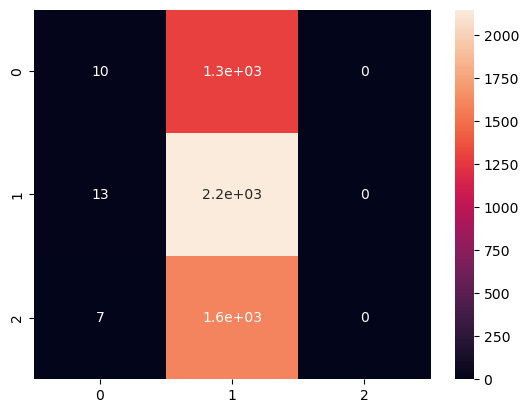

In [70]:
import seaborn as sns
sns.heatmap(cf_mat1, annot=True)

#### phase2 model

In [71]:
cf_mat2=confusion_matrix(rphase2, pphase2, labels=[0, 1, 2])
cf_mat2

array([[936, 165, 197],
       [966, 914, 283],
       [750, 203, 653]], dtype=int64)

<AxesSubplot:>

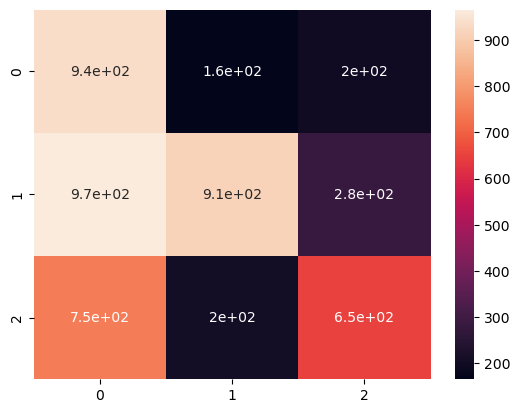

In [72]:
sns.heatmap(cf_mat2, annot=True)

#### phase3 model

In [73]:
cf_mat3=confusion_matrix(rphase3, pphase3, labels=[0, 1, 2])
cf_mat3

array([[ 743,  304,  251],
       [ 641, 1176,  346],
       [ 498,  313,  795]], dtype=int64)

<AxesSubplot:>

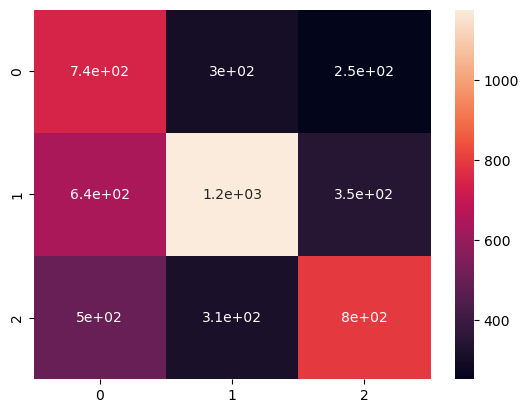

In [74]:
sns.heatmap(cf_mat3, annot=True)

## Subpart2: Using SOTA pre-trained models for multimodal classification
## Method 1

In [9]:
from PIL import Image
from transformers import BlipConfig, BlipModel
from transformers import BlipTextConfig, BlipTextModel
from transformers import BlipTextConfig, BlipTextModel
from transformers import BlipVisionConfig, BlipVisionModel

In [10]:
from PIL import Image
import requests
from transformers import AutoProcessor, BlipForQuestionAnswering

model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
processor = AutoProcessor.from_pretrained("Salesforce/blip-vqa-base")

In [11]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor, text):
        self.dataset = dataset
        self.processor = processor
        self.text = text
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item[0][0], text=self.text[idx], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

In [12]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

model.train()
model = model.to(device)

def train_loop(dataloader, model, optimizer):
    print(len(dataloader.dataset))
    for idx, batch in enumerate(dataloader):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
        loss = outputs.loss
        print("Loss:", loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(idx)

In [13]:
def test_loop(dataloader, model):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            input_ids = batch.pop("input_ids").to(device)
            pixel_values = batch.pop("pixel_values").to(device)
            outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
            loss = outputs.loss
            print("Loss:", loss.item())



In [14]:
blip_trainset = ImageCaptioningDataset(facestrainset, processor, corpus_text_train)

blip_testset = ImageCaptioningDataset(facestestset, processor, corpus_text_test)


In [15]:
batch_size = 2

blip_trainloader =  torch.utils.data.DataLoader(dataset=blip_trainset, batch_size=batch_size,shuffle=True)
blip_testloader =  torch.utils.data.DataLoader(dataset=blip_testset, batch_size=batch_size,shuffle=False)

In [16]:
learning_rate = 1e-5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, eps=1e-8) 

In [17]:
for i in range(5):
    print('======================================================')
    print('epoch '+str(i))
    train_loop(blip_trainloader, model, optimizer)
    test_loop(blip_testloader, model)


epoch 0
20240


C:\Users\Asus\anaconda3\lib\site-packages\torchvision\transforms\functional.py:149: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:205.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 3.20 GiB already allocated; 0 bytes free; 3.44 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### Method 2

In [9]:
from PIL import Image
import requests
from transformers import AutoProcessor, BlipModel

encoder_model = BlipModel.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")


C:\Users\Asus\anaconda3\lib\site-packages\huggingface_hub\file_download.py:129: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Asus\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Some weights of the model checkpoint at Salesforce/blip-image-captioning-base were not used when initializing BlipModel: ['text_decoder.bert.encoder.layer.3.attention.output.dense.weight', 'text_decoder.bert.encoder.layer.6.attention.self.query.bias', 'text_decoder.bert.encoder.layer.0.crossattention.output.dense.bias', 'text_decoder.bert.encoder.layer.6.output.dense.bias', 'text_decoder.bert.encoder.layer.8.attention.self.value.bias', 'text_decoder.bert.encoder.layer.1.attention.output.dense.weight', 'text_decoder.bert.encoder.layer.11.crossattention.self.query.weight', 'text_decoder.bert.encoder.layer.4.attention.self.query.weight', 'text_decoder.bert.encoder.layer.6.attention.self.key.bias', 'text_decoder.bert.encoder.layer.7.crossattention.output.dense.weight', 'text_decoder.bert.encoder.layer.7.output.dense.bias', 'text_decoder.bert.encoder.layer.3.crossattention.self.key.weight', 'text_decoder.bert.encoder.layer.10.crossattention.self.key.weight', 'text_decoder.bert.encoder.layer

In [11]:
from torch.utils.data import Dataset, DataLoader

class EncodingDataset(Dataset):
    def __init__(self, dataset, processor, text, model):
        self.model = model
        self.dataset = dataset
        self.processor = processor
        self.text = text
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        
        inputs = self.processor(images=item[0][0].to(device), text=self.text[idx],
                                         padding="max_length", return_tensors="pt").to(device)
        
        outputs = self.model(**inputs)
        text_embeds = outputs['image_embeds']
        image_embeds = outputs['image_embeds']
        y = item[1]
        return text_embeds, image_embeds, y
    
    

In [12]:
blip_encoder_trainset = EncodingDataset(facestrainset, processor, corpus_text_train, encoder_model)

blip_encoder_testset = EncodingDataset(facestestset, processor, corpus_text_test, encoder_model)

In [13]:
batch_size = 2

blip_trainloader =  torch.utils.data.DataLoader(dataset=blip_encoder_trainset, batch_size=batch_size,shuffle=True)
blip_testloader =  torch.utils.data.DataLoader(dataset=blip_encoder_testset, batch_size=batch_size,shuffle=False)

In [14]:
class BLIP_MLP(nn.Module):
    def __init__(self, encoder_model):
        super(BLIP_MLP,self).__init__()
        self.encoder_model = encoder_model
        for param in self.encoder_model.parameters():
            param.requires_grad = False
        
        encoder_model.eval()
        
        self.flatten = nn.Flatten()  
        self.fc1 = nn.Linear(1024,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,16)
        self.fc5 = nn.Linear(16,3)
        self.relu = nn.ReLU()

       
    def forward(self,img_embeddings, txt_embeddings):
        #print(img_embeddings.shape)
        combined_out = torch.cat((img_embeddings,txt_embeddings), 1)
        x = self.flatten(combined_out)      
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        
        return(x)

In [15]:
blip_model = BLIP_MLP(encoder_model).to(device)

In [100]:
learning_rate = 1e-5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(blip_model.parameters(), lr=learning_rate, eps=1e-8) 

In [106]:
import torch

blip_model.train()
blip_model = blip_model.to(device)

def train_loop(dataloader, model, optimizer):
    print(len(dataloader.dataset))
    for idx, (txt, img, y) in enumerate(dataloader):        
        pred = model(img, txt).to(device)
        loss = loss_fn(pred, y.to(device))
        if idx%100 == 0:
            print("batch "+str(idx)+" Loss:", loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        

        
def test_loop(dataloader, model):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for idx, (txt, img, y) in enumerate(dataloader):
            
            pred = model(img, txt).to(device)
            loss = loss_fn(pred, y.to(device))
            
            test_loss += loss_fn(pred, y.to(device)).item()
            correct += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
        


In [19]:
for i in range(5):
    print('======================================================')
    print('epoch '+str(i))
    train_loop(blip_trainloader, blip_model, optimizer)
    #test_loop(blip_testloader, blip_model)


epoch 0
20240
batch 0 Loss: 1.0687110424041748
batch 100 Loss: 1.0626153945922852
batch 200 Loss: 1.1831700801849365
batch 300 Loss: 1.0615195035934448
batch 400 Loss: 0.9464712142944336
batch 500 Loss: 1.1752591133117676
batch 600 Loss: 1.0698866844177246
batch 700 Loss: 1.175132155418396
batch 800 Loss: 1.0600223541259766
batch 900 Loss: 0.9457628726959229
batch 1000 Loss: 0.9459049701690674
batch 1100 Loss: 1.1961874961853027
batch 1200 Loss: 1.0594148635864258
batch 1300 Loss: 1.0588722229003906
batch 1400 Loss: 1.1858227252960205
batch 1500 Loss: 1.0583053827285767
batch 1600 Loss: 1.1868078708648682
batch 1700 Loss: 1.1857842206954956
batch 1800 Loss: 1.0721724033355713
batch 1900 Loss: 1.1856210231781006
batch 2000 Loss: 0.9433678984642029
batch 2100 Loss: 1.1710764169692993
batch 2200 Loss: 1.0562189817428589
batch 2300 Loss: 1.0738714933395386
batch 2400 Loss: 1.169842004776001
batch 2500 Loss: 1.0738651752471924
batch 2600 Loss: 1.1694175004959106
batch 2700 Loss: 1.073054790

KeyboardInterrupt: 

In [20]:
torch.save(blip_trainloader, "Method2.pth")

In [107]:
test_loop(blip_testloader, blip_model)

Test Error: 
 Accuracy: 42.7%, Avg loss: 1.085744 



### Method 3

In [ ]:
from PIL import Image
import requests
from transformers import PerceiverModel, PerceiverConfig
from transformers import AutoProcessor, BlipModel

encoder_model = BlipModel.from_pretrained("Salesforce/blip-image-captioning-base")

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

from transformers import AutoTokenizer, PerceiverForMaskedLM
import torch

tokenizer = AutoTokenizer.from_pretrained("deepmind/language-perceiver")
model = PerceiverForMaskedLM.from_pretrained("deepmind/language-perceiver")

In [ ]:
from torch.utils.data import Dataset, DataLoader

class EncodingDataset(Dataset):
    def __init__(self, dataset, processor, text, model):
        self.model = model
        self.dataset = dataset
        self.processor = processor
        self.text = text
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        
        inputs = self.processor(images=item[0][0].to(device), text=self.text[idx],
                                         padding="max_length", return_tensors="pt").to(device)
        
        outputs = self.model(**inputs)
        text_embeds = outputs['image_embeds']
        image_embeds = outputs['image_embeds']
        y = item[1]
        return text_embeds, image_embeds, y
    
    

In [ ]:
perc_encoder_trainset = EncodingDataset(facestrainset, processor, corpus_text_train, encoder_model)

perc_encoder_testset = EncodingDataset(facestestset, processor, corpus_text_test, encoder_model)

In [ ]:
batch_size = 2

perc_trainloader =  torch.utils.data.DataLoader(dataset=perc_encoder_trainset, batch_size=batch_size,shuffle=True)
perc_testloader =  torch.utils.data.DataLoader(dataset=perc_encoder_testset, batch_size=batch_size,shuffle=False)

In [ ]:
from transformers.models.perceiver.modeling_perceiver import PerceiverClassificationDecoder
config = PerceiverConfig()
config.num_labels = 3
config.d_model = 512

perceiver = PerceiverModel(
            config=config,
            decoder=PerceiverClassificationDecoder(
                config,
                num_channels=config.d_latents,
                trainable_position_encoding_kwargs=dict(num_channels=config.d_latents, index_dims=1),
                use_query_residual=True,)).to(device)


In [ ]:
class Perceiver_decoder(nn.Module):
    
    def __init__(self, perceiver):
        super().__init__()
        
        self.perceiver = perceiver
    
    def forward(self, img_embeddings, txt_embeddings):
        
        combined_out = torch.cat((img_embeddings,txt_embeddings), dim = 1)
        #print(combined_out.shape)
        x = self.perceiver(combined_out).logits
        return x

In [ ]:
perc_classifier = Perceiver_decoder(perceiver)

In [ ]:
learning_rate = 1e-5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(perc_classifier.parameters(), lr=learning_rate, eps=1e-8) 

In [ ]:
import torch

perc_classifier.train()

def train_loop(dataloader, model, optimizer):
    print(len(dataloader.dataset))
    for idx, (txt, img, y) in enumerate(dataloader):        
        pred = model(img, txt).to(device)
        loss = loss_fn(pred, y.to(device))
        if idx%100 == 0:
            print("batch "+str(idx)+" Loss:", loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        

        
def test_loop(dataloader, model):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for idx, (txt, img, y) in enumerate(dataloader):
            
            pred = model(img, txt).to(device)
            loss = loss_fn(pred, y.to(device))
            
            test_loss += loss.item()
            correct += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
        


In [ ]:
for i in range(5):
    print('======================================================')
    print('epoch '+str(i))
    train_loop(perc_trainloader, perc_classifier, optimizer)
    test_loop(perc_testloader, perc_classifier)


# Part2: Multimodal Dataset for Weakly supervised learning

### step1

In [43]:
from transformers import BertTokenizer

class unlabeledata(Dataset):    
    def __init__(self, english_text_add, address, transform=None, target_transform=None):
    
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.transform = transform
        self.address = address
        self.target_transform = target_transform
        
        self.corpus_text_train = []
        txt_file = open(english_text_add, encoding="utf8")
        for line in txt_file:
            a = line.strip()
            self.corpus_text_train.append(re.sub(r'[^\w\s]','', a).lower())

        self.texts = [tokenizer(self.corpus_text_train[i], padding='max_length', max_length = 18, truncation=True, return_tensors="pt")['input_ids'] for i in range(len(self.corpus_text_train))]


    def __len__(self):
        return len(self.corpus_text_train)

    def __getitem__(self, idx):  
        self.Z = self.texts[idx]
        self.X = self.transform(plt.imread(self.address+str(idx)+'.jpg'))   
        return self.X, self.Z

In [45]:
batch_size = 8
unlabeled_image_transform = transforms.Compose([transforms.ToTensor(),transforms.Resize((128,128))])

unlabeled_image_trainset = unlabeledata("./MSCTD_dataset/test.origin.txt" ,"./newdataset/", unlabeled_image_transform)


In [47]:
class ConcatNet(nn.Module):
    def __init__(self):
        super(ConcatNet,self).__init__()              
        self.pooling = nn.AvgPool2d(2)
       
        self.conv1 = nn.Conv2d(512,128,kernel_size = 3, padding = 'same')
        self.batch1 = nn.BatchNorm2d(128)
       
       
        self.conv2 = nn.Conv2d(128,32,kernel_size = 3, padding = 'same')
        self.batch2 = nn.BatchNorm2d(32)
       
        self.conv3 = nn.Conv2d(32,8,kernel_size = 3, padding = 'same')
        self.batch3 = nn.BatchNorm2d(8)

       
       
        self.flatten = nn.Flatten()  
        self.fc1 = nn.Linear(128,64)
        self.fc2 = nn.Linear(64,16)
        self.fc3 = nn.Linear(16,3)
       
       
        self.maxpool = nn.MaxPool2d(kernel_size = 2)
       
        self.relu = nn.ReLU()

       
    def forward(self,inputs):
        x = self.conv1(inputs)
        x = self.batch1(x)
        x = self.relu(x)

       
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.relu(x)
       
        x = self.conv3(x)
        x = self.batch3(x)
        x = self.relu(x)
       
       

        x = self.flatten(x)      
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
       
        return(x)

In [48]:
image_backbone = torch.load("Part2.pth")

In [49]:
from transformers import BertModel
class BertClassifier(nn.Module):

    def __init__(self):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.fc1 = nn.Linear(768, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 3)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        
        out = self.bert(inputs)
        output = self.fc1(out[1])
        output = self.relu(output)
        output = self.fc2(output)
        output = self.relu(output)
        output = self.fc3(output)

        return output

In [50]:
text_backbone = torch.load("bertclassifier.pth")

### step2

In [51]:
text_backbone.eval()
for params in text_backbone.parameters():
    params.requires_grad=False
    

In [52]:
for params in image_backbone.parameters():
    params.requires_grad=False
for params in image_backbone[1].fc1.parameters():
    params.requires_grad=True
for params in image_backbone[1].fc2.parameters():
    params.requires_grad=True
for params in image_backbone[1].fc3.parameters():
    params.requires_grad=True

In [53]:
image_backbone.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [54]:
class pseudolabeledata(Dataset):    
    def __init__(self, data, transform=None, target_transform=None):
    
        self.data = data
        self.labels = [text_backbone(data[i][1]).squeeze(0) for i in range(len(data))] 
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):  
        self.X = self.data[idx][0]   
        self.y = self.labels[idx]
        return self.X, self.y
    

In [55]:
pseudolabeled_trainset = pseudolabeledata(unlabeled_image_trainset)

In [56]:
learning_rate = 1e-4
batch_size =8
epochs = 10

In [57]:
unlabeled_trainloader = torch.utils.data.DataLoader(pseudolabeled_trainset, batch_size=batch_size,shuffle=True)


In [58]:
loss_fn = nn.CrossEntropyLoss()

In [59]:
optimizer = torch.optim.Adam(image_backbone.parameters(), lr=learning_rate)

In [61]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    correct=0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X=X.to(device)
        y=y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y.argmax(1))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    correct /= size
    print(f"Train : Accuracy between model's output and pseudo labels: {(100*correct):>0.1f}%\n") 



In [62]:
for t in range(2):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(unlabeled_trainloader, image_backbone, loss_fn, optimizer)
    #test_loop(unlabeled_trainloader, image_backbone, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.023788  [    0/ 5147]
loss: 1.158622  [  800/ 5147]
loss: 0.998282  [ 1600/ 5147]
loss: 1.091634  [ 2400/ 5147]
loss: 1.034170  [ 3200/ 5147]
loss: 1.112459  [ 4000/ 5147]
loss: 1.188124  [ 4800/ 5147]
Train : Accuracy between model's output and pseudo labels: 40.0%

Epoch 2
-------------------------------
loss: 1.171019  [    0/ 5147]
loss: 0.992504  [  800/ 5147]
loss: 1.065792  [ 1600/ 5147]
loss: 1.000763  [ 2400/ 5147]
loss: 1.068504  [ 3200/ 5147]
loss: 1.088071  [ 4000/ 5147]
loss: 1.111302  [ 4800/ 5147]
Train : Accuracy between model's output and pseudo labels: 39.6%

Done!


In [63]:
from transformers import BertTokenizer

class unlabeledatatest(Dataset):    
    def __init__(self, english_text_add, address, transform=None, target_transform=None):
    
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.transform = transform
        self.address = address
        self.target_transform = target_transform
        
        self.corpus_text_train = []
        txt_file = open(english_text_add, encoding="utf8")
        for line in txt_file:
            a = line.strip()
            self.corpus_text_train.append(re.sub(r'[^\w\s]','', a).lower())

        self.texts = [tokenizer(self.corpus_text_train[i], padding='max_length', max_length = 18, truncation=True, return_tensors="pt")['input_ids'] for i in range(len(self.corpus_text_train))]


    def __len__(self):
        return len(self.corpus_text_train)

    def __getitem__(self, idx):  
        self.Z = self.texts[idx]
        self.X = self.transform(plt.imread(self.address+str(idx+5147)+'.jpg'))   
        return self.X, self.Z

In [66]:
batch_size = 8
unlabeled_image_transform = transforms.Compose([transforms.ToTensor(),transforms.Resize((128,128))])

unlabeled_image_testset = unlabeledatatest("./MSCTD_dataset/newtest.txt" ,"./newdatasettest/", unlabeled_image_transform)


In [67]:
pseudolabeled_testset = pseudolabeledata(unlabeled_image_testset)

In [68]:
unlabeled_testloader = torch.utils.data.DataLoader(pseudolabeled_testset, batch_size=batch_size,shuffle=True)


In [71]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X=X.to(device)
            y=y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y.argmax(1)).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy between model's output and pseudo labels: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [72]:
test_loop(unlabeled_testloader, image_backbone, loss_fn)

Test Error: 
 Accuracy between model's output and pseudo labels: 43.1%, Avg loss: 1.068502 



In [111]:
torch.save(image_backbone, "phase3_part2.pth")

### evaluation

The link of the new dataset is as follows: https://github.com/ShannonAI/OpenViDial/blob/main/datasets/README.md

Further information can be obtained from the link.

In [83]:
def evaluation(dataset, model):
    predicted=[]
    real=[]
    with torch.no_grad():
        for i in range(len(dataset)):
            X=dataset[i][0].reshape(1,3,128,128)
            y=dataset[i][1].argmax()
            pred = model(X).argmax()
            predicted.append(pred)
            real.append(y)
    return predicted, real

In [84]:
pnewdata, rnewdata = evaluation(pseudolabeled_testset, image_backbone.to("cpu"))

#### Accuracy for Weakly supervised trained model : 43.1%

#### f1 score for Weakly supervised trained model

In [88]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(rnewdata, pnewdata))

              precision    recall  f1-score   support

           0       0.47      0.02      0.04       322
           1       0.45      0.99      0.62       452
           2       0.00      0.00      0.00       227

    accuracy                           0.45      1001
   macro avg       0.31      0.34      0.22      1001
weighted avg       0.35      0.45      0.29      1001



C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### confusion matrix for Weakly supervised trained model

In [89]:
from sklearn.metrics import confusion_matrix

cf_mat1=confusion_matrix(rnewdata, pnewdata, labels=[0, 1, 2])
cf_mat1

array([[  7, 315,   0],
       [  6, 446,   0],
       [  2, 225,   0]], dtype=int64)

<AxesSubplot:>

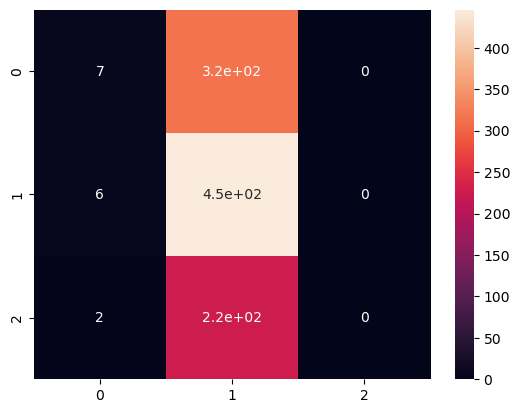

In [90]:
import seaborn as sns
sns.heatmap(cf_mat1, annot=True)

In [94]:
phase1_model = torch.load('Part2.pth').to(device)

In [92]:
pnewdata2, rnewdata2 = evaluation(pseudolabeled_testset, phase1_model.to("cpu"))

In [ ]:
phase1_model.to(device)

In [95]:
test_loop(unlabeled_testloader, phase1_model, loss_fn)

Test Error: 
 Accuracy between model's output and pseudo labels: 43.7%, Avg loss: 1.067834 



#### Accuracy for phase1 model on the new dataset : 43.7%

#### f1 score for phase1 model on the new dataset 

In [97]:
print(classification_report(rnewdata2, pnewdata2))

              precision    recall  f1-score   support

           0       0.36      0.01      0.02       322
           1       0.45      0.99      0.62       452
           2       0.00      0.00      0.00       227

    accuracy                           0.45      1001
   macro avg       0.27      0.33      0.21      1001
weighted avg       0.32      0.45      0.29      1001



C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### confusion matrix for phase1 model on the new dataset 

In [98]:
cf_mat2=confusion_matrix(rnewdata2, pnewdata2, labels=[0, 1, 2])
cf_mat2

array([[  4, 318,   0],
       [  5, 447,   0],
       [  2, 225,   0]], dtype=int64)

<AxesSubplot:>

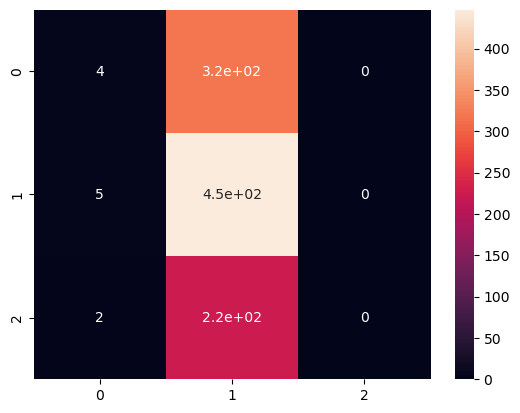

In [99]:
sns.heatmap(cf_mat2, annot=True)